In the previous notebook we made sure all the offsets etc were correct. In this notebook we slowly work towards recursive prediction:

In [1]:
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt
from recurrent_kernel import recurrent_kernel, erf_kernel, weighted_dot, update_fn, diagonal_update_fn, train, predict
from jax.lax import scan

%config InlineBackend.figure_format = 'svg'
%load_ext autoreload 
%autoreload 2

In [2]:
# Data
data_train = jnp.load('u_train.npy')
data_test = jnp.load('u_test.npy')
data_full = jnp.concatenate([data_train, data_test])

# These are the baselines from explicit reservoirs
K_baseline_train = jnp.load('K_baseline_train.npy')
K_baseline_test = jnp.load('K_baseline_test.npy')
K_baseline_full = jnp.concatenate([K_baseline_train, K_baseline_test], axis=0)

# This is the explicit reservoir run over all data
K_true = jnp.load('K_true.npy')

In [3]:
scaling = (0.4, 0.9, 0.4)
renorm = 0.11
alpha = 1e-2
N_train = 10000
N_init = 50
dot_fn = weighted_dot(*scaling)

Lets get our previous results in first:

In [4]:
K_full, _ = recurrent_kernel(data_full, erf_kernel, scaling)

In [5]:
K_train, _ = recurrent_kernel(data_train, erf_kernel, scaling)
K_predict_ini = K_train[-1, 1:]

# Gram to iterate over
gram_predict_ini = jnp.dot(data_train[[-1]], data_train[:-1].T)
gram_predict_test = jnp.dot(data_test[:-1], data_train[:-1].T)
gram_predict = jnp.concatenate([gram_predict_ini, gram_predict_test], axis=0)

# Getting back uu
gram = jnp.dot(data_train, data_train.T)
dot_fn = weighted_dot(*scaling)
uu = dot_fn(jnp.diag(gram)[:-1], jnp.diag(K_train)[:-1])

# Calculating vv
K_diag_predict = jnp.diag(K_full)[(N_train -1): -1]
gram_diag_predict = jnp.concatenate([gram[-1, [-1]], jnp.diag(jnp.dot(data_test[:-1], data_test[:-1].T))])
vv = dot_fn(gram_diag_predict, K_diag_predict)

In [6]:
def predict_fn(kernel_fn, dot_fn, uu):
    def predict(carry, inputs):
        k_prev = carry
        gram_prev, vv = inputs
        
        # Updating kernel
        k_prev = jnp.pad(k_prev[:-1], (1, 0))
        uv = dot_fn(gram_prev, k_prev)
        k = kernel_fn(uv, uu, vv)
        
        return k, k
    return predict

In [7]:
rec_pred_fn = predict_fn(erf_kernel, dot_fn, uu)
_, K_test = jax.lax.scan(rec_pred_fn, K_predict_ini, (gram_predict, vv))
K_test = jnp.pad(K_test, ((0, 0), (1, 0))) # Need to add in the zeros

In [8]:
print(jnp.allclose(K_full[N_train:, :N_train], K_test, atol=1e-7))

True


# Improvement 1: training func returning uu

If we have the training function returning uu, we can get rid of a bit of code:

In [9]:
K_train, uu_train = recurrent_kernel(data_train, erf_kernel, scaling)

In [10]:
jnp.allclose(uu, uu_train)

DeviceArray(True, dtype=bool)

Great - that works. The code now becomes:

In [11]:
K_full, _ = recurrent_kernel(data_full, erf_kernel, scaling)
K_train, uu = recurrent_kernel(data_train, erf_kernel, scaling)
K_predict_ini = K_train[-1, 1:]

# Gram to iterate over
gram_predict_ini = jnp.dot(data_train[[-1]], data_train[:-1].T)
gram_predict_test = jnp.dot(data_test[:-1], data_train[:-1].T)
gram_predict = jnp.concatenate([gram_predict_ini, gram_predict_test], axis=0)

# Calculating vv
K_diag_predict = jnp.diag(K_full)[(N_train -1): -1]
gram_diag_predict = jnp.concatenate([gram[-1, [-1]], jnp.diag(jnp.dot(data_test[:-1], data_test[:-1].T))])
vv = dot_fn(gram_diag_predict, K_diag_predict)

In [12]:
def predict_fn(kernel_fn, dot_fn, uu):
    def predict(carry, inputs):
        k_prev = carry
        gram_prev, vv = inputs
        
        # Updating kernel
        k_prev = jnp.pad(k_prev[:-1], (1, 0))
        uv = dot_fn(gram_prev, k_prev)
        k = kernel_fn(uv, uu, vv)
        
        return k, k
    return predict

In [13]:
rec_pred_fn = predict_fn(erf_kernel, dot_fn, uu)
_, K_test = jax.lax.scan(rec_pred_fn, K_predict_ini, (gram_predict, vv))
K_test = jnp.pad(K_test, ((0, 0), (1, 0))) # Need to add in the zeros

In [14]:
print(jnp.allclose(K_full[N_train:, :N_train], K_test, atol=1e-7))

True


# Improvement 2 - adding last of train to first of test

The code becomes much clearer if we add the last of the train set to the first of the test and remove the last:

In [15]:
K_full, _ = recurrent_kernel(data_full, erf_kernel, scaling)
K_train, uu = recurrent_kernel(data_train, erf_kernel, scaling)

# Creating augmented data
augmented_data_test = jnp.concatenate((data_train[[-1]], data_test), axis=0)
gram_predict = jnp.dot(augmented_data_test[:-1], data_train[:-1].T)

# Calculating vv
K_diag_predict = jnp.diag(K_full)[(N_train-1):-1]
gram_diag_predict = jnp.diag(jnp.dot(augmented_data_test[:-1], augmented_data_test[:-1].T))
vv = dot_fn(gram_diag_predict, K_diag_predict)

In [16]:
def predict_fn(kernel_fn, dot_fn, uu):
    def predict(carry, inputs):
        k_prev = carry
        gram_prev, vv = inputs
        
        # Updating kernel
        k_prev = jnp.pad(k_prev[:-1], (1, 0))
        uv = dot_fn(gram_prev, k_prev)
        k = kernel_fn(uv, uu, vv)
        
        return k, k
    return predict

In [17]:
rec_pred_fn = predict_fn(erf_kernel, dot_fn, uu)
_, K_test = jax.lax.scan(rec_pred_fn, K_train[-1, 1:], (gram_predict, vv))
K_test = jnp.pad(K_test, ((0, 0), (1, 0))) # Need to add in the zeros

In [18]:
print(jnp.allclose(K_full[N_train:, :N_train], K_test, atol=1e-7))

True


Great :-)

# Improvement 3 - calculating vv inside the predict function

Now the last part before we need to actually predict; calculating vv inside the function.

In [19]:
K_full, _ = recurrent_kernel(data_full, erf_kernel, scaling)

In [20]:
def predict_fn(kernel_fn, dot_fn, uu):
    def predict(carry, inputs):
        k_prev, k_diag_prev = carry
        gram_prev, gram_diag_prev = inputs
        
        # Updating test/test diagonal
        vv = dot_fn(gram_diag_prev, k_diag_prev)
        k_diag = kernel_fn(vv, vv, vv)
        
        # Updating test/train kernel
        k_prev = jnp.pad(k_prev[:-1], (1, 0))
        uv = dot_fn(gram_prev, k_prev)
        k = kernel_fn(uv, uu, vv)
    
        return (k, k_diag), k
    return predict

In [21]:
rec_pred_fn = predict_fn(erf_kernel, dot_fn, uu)

In [22]:
K_train, uu = recurrent_kernel(data_train, erf_kernel, scaling)

# Creating augmented data and precalculating 
augmented_data_test = jnp.concatenate((data_train[[-1]], data_test), axis=0)
gram_predict = jnp.dot(augmented_data_test[:-1], data_train[:-1].T)
gram_diag_predict = jnp.diag(jnp.dot(augmented_data_test[:-1], augmented_data_test[:-1].T))

# Running test 
_, K_test = jax.lax.scan(rec_pred_fn, (K_train[-1, 1:], K_train[-1, -1]), (gram_predict, gram_diag_predict))
K_test = jnp.pad(K_test, ((0, 0), (1, 0))) # Need to add in the zeros

In [23]:
print(jnp.allclose(K_full[N_train:, :N_train], K_test, atol=1e-7))

True


Okay that works too - great. Next step is to not precalculate the gram matrix:

# Improvement 4 - Not precalculating gram

We now calculate vv correctly in the update function. Next step is to remove the precalculatinf of the gram and just iterate over the dataset:

In [24]:
K_full, _ = recurrent_kernel(data_full, erf_kernel, scaling)

In [25]:
def predict_fn(data_train, kernel_fn, dot_fn, uu):
    def predict(carry, inputs):
        k_prev, k_diag_prev = carry
        data_test = inputs
        
        # Calculating grams
        gram_diag_prev = jnp.dot(data_test, data_test.T)
        gram_prev = jnp.dot(data_test, data_train.T)
        
        # Updating test/test diagonal
        vv = dot_fn(gram_diag_prev, k_diag_prev)
        k_diag = kernel_fn(vv, vv, vv)
        
        # Updating test/train kernel
        k_prev = jnp.pad(k_prev[:-1], (1, 0))
        uv = dot_fn(gram_prev, k_prev)
        k = kernel_fn(uv, uu, vv)
    
        return (k, k_diag), k
    return predict

In [26]:
K_train, uu = recurrent_kernel(data_train, erf_kernel, scaling)
rec_pred_fn = predict_fn(data_train[:-1], erf_kernel, dot_fn, uu) # up until last element

In [27]:
augmented_data_test = jnp.concatenate((data_train[[-1]], data_test), axis=0)
_, K_test = jax.lax.scan(rec_pred_fn, (K_train[-1, 1:], K_train[-1, -1]), augmented_data_test[:-1])
K_test = jnp.pad(K_test, ((0, 0), (1, 0))) # Need to add in the zeros

In [28]:
print(jnp.allclose(K_full[N_train:, :N_train], K_test, atol=1e-7))

True


# Improvement 5 - Predicting output

Now the final step is to do recursive prediction. Lets calculate the output layer:

In [142]:
K_full, _ = recurrent_kernel(data_full, erf_kernel, scaling)

In [143]:
K_train, _ = recurrent_kernel(data_train, erf_kernel, scaling)

# Need to shift and add zeros again
K_train += renorm * jnp.pad(jnp.dot(data_train[:-1], data_train[:-1].T), ((1, 0), (1, 0)))
K_train = K_train[N_init:, N_init:]

In [144]:
alpha =1e-2 # cant go below 1e-4, thats reasonable
K_train = jax.ops.index_add(K_train, jnp.diag_indices(K_train.shape[0]), alpha)
c, low = jax.scipy.linalg.cho_factor(K_train, check_finite=False)
W_out = jax.scipy.linalg.cho_solve((c, low), data_train[N_init:], check_finite=False)

In [145]:
W_out.shape

(9950, 100)

In [146]:
def predict_fn(data_train, kernel_fn, dot_fn, uu, W_out, n_init, renorm):
    def predict(carry, inputs):
        k_prev, k_diag_prev = carry
        data_test = inputs

        # Calculating grams
        gram_diag_prev = jnp.dot(data_test, data_test.T)
        gram_prev = jnp.dot(data_test, data_train.T)
        
        # Updating test/test diagonal
        vv = dot_fn(gram_diag_prev, k_diag_prev)
        k_diag = kernel_fn(vv, vv, vv)
        
        # Updating test/train kernel
        k_prev = jnp.pad(k_prev[:-1], (1, 0))
        uv = dot_fn(gram_prev, k_prev)
        k = kernel_fn(uv, uu, vv)
        
        # Prediction
        prediction = jnp.dot((k + renorm * gram_prev)[n_init-1:], W_out)
        return (k, k_diag), (k, prediction)
    return predict

In [147]:
K_train, uu = recurrent_kernel(data_train, erf_kernel, scaling)
rec_pred_fn = predict_fn(data_train[:-1], erf_kernel, dot_fn, uu, W_out, n_init=N_init, renorm=renorm) # up until last element

In [148]:
augmented_data_test = jnp.concatenate((data_train[[-1]], data_test), axis=0)
_, (K_test, prediction) = jax.lax.scan(rec_pred_fn, (K_train[-1, 1:], K_train[-1, -1]), augmented_data_test[:-1])
K_test = jnp.pad(K_test, ((0, 0), (1, 0))) # Need to add in the zeros

In [149]:
print(jnp.allclose(K_full[N_train:, :N_train], K_test, atol=1e-7))

True


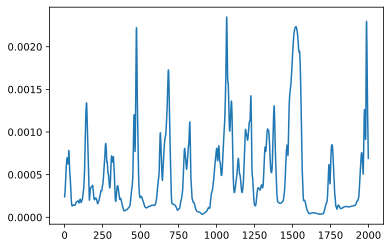

In [150]:
plt.plot(jnp.mean(jnp.abs(prediction - data_test), axis=1))

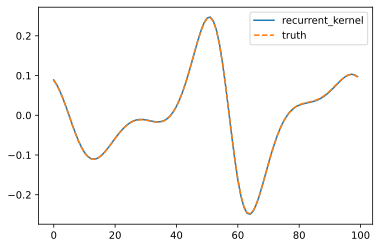

In [151]:
frame = -1
plt.plot(prediction[frame], label='recurrent_kernel')
plt.plot(data_test[frame], '--', label='truth')

plt.legend()

Perfect! Let's do an internal consistency check, to see if we implemented n_init correctly. Predicting using the output should give the same as the prediction from kernel:"

In [156]:
# N_init-1 cause we already cut off the first one
prediction_kernel = jnp.dot((K_test[:, 1:] + renorm * jnp.dot(augmented_data_test[:-1], data_train[:-1].T))[:, N_init-1:], W_out)

In [157]:
jnp.allclose(prediction, prediction_kernel, atol=1e-5)

DeviceArray(True, dtype=bool)

In [160]:
prediction_kernel = jnp.dot((K_test[:, N_init:] + renorm * jnp.dot(augmented_data_test[:-1], data_train[N_init-1:-1].T)), W_out)

In [161]:
jnp.allclose(prediction, prediction_kernel, atol=1e-5)

DeviceArray(True, dtype=bool)

# Final stage - recurrent prediction

In [91]:
K_train, _ = recurrent_kernel(data_train, erf_kernel, scaling)

# Need to shift and add zeros again
K_train += renorm * jnp.pad(jnp.dot(data_train[:-1], data_train[:-1].T), ((1, 0), (1, 0)))
K_train = K_train[N_init:, N_init:]

alpha = 1e-2
K_train = jax.ops.index_add(K_train, jnp.diag_indices(K_train.shape[0]), alpha)
c, low = jax.scipy.linalg.cho_factor(K_train, check_finite=False)
W_out = jax.scipy.linalg.cho_solve((c, low), data_train[N_init:], check_finite=False)

In [117]:
def predict_fn(data_train, kernel_fn, dot_fn, uu, W_out, n_init, renorm):
    def predict(carry, _):
        k_prev, k_diag_prev, data_test = carry
        
        # Calculating grams
        gram_diag_prev = jnp.dot(data_test, data_test.T)
        gram_prev = jnp.dot(data_test, data_train.T)
        
        # Updating test/test diagonal
        vv = dot_fn(gram_diag_prev, k_diag_prev)
        k_diag = kernel_fn(vv, vv, vv)
        
        # Updating test/train kernel
        k_prev = jnp.pad(k_prev[:-1], (1, 0))
        uv = dot_fn(gram_prev, k_prev)
        k = kernel_fn(uv, uu, vv)
        
        # Prediction
        prediction = jnp.dot((k + renorm * gram_prev)[n_init-1:], W_out)
   
        return (k, k_diag, prediction), (k, prediction)
    return predict

In [118]:
K_train, uu = recurrent_kernel(data_train, erf_kernel, scaling)
rec_pred_fn = predict_fn(data_train[:-1], erf_kernel, dot_fn, uu, W_out, n_init=N_init, renorm=renorm) # up until last element

In [119]:
_, (K_test, prediction) = jax.lax.scan(rec_pred_fn, (K_train[-1, 1:], K_train[-1, -1], data_train[-1]), None, length=2000)
K_test = jnp.pad(K_test.squeeze(), ((0, 0), (1, 0))) # Need to add in the zeros

lets look at the diff between the explicit and the kernel function:

In [120]:
K_test.shape

(2000, 10000)

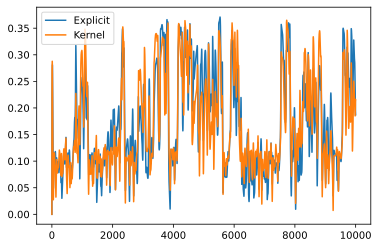

In [121]:
frame = 100
plt.plot(K_baseline_test[frame, :], label='Explicit')
plt.plot(K_test[frame, :], label='Kernel')

plt.legend()

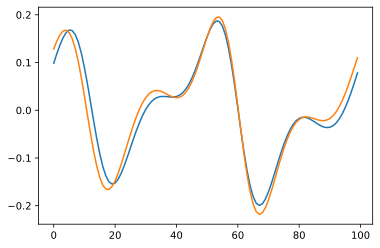

In [122]:
frame = 50
plt.plot(data_test[frame])
plt.plot(prediction[frame])

let's look at the error in time:

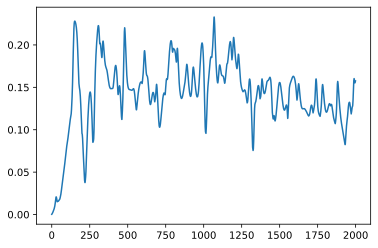

In [123]:
plt.plot(jnp.mean(jnp.abs(data_test - prediction), axis=1))

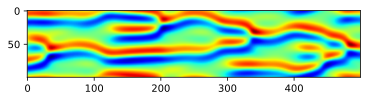

In [124]:
plt.imshow(prediction[:500].T, cmap='jet')

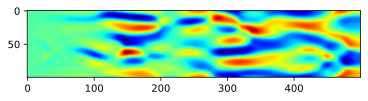

In [125]:
plt.imshow(prediction[:500].T - data_test[:500].T, cmap='jet')

Wild. Now lets time:

In [126]:
K_train, uu = recurrent_kernel(data_train, erf_kernel, scaling)
rec_pred_fn = predict_fn(data_train[:-1], erf_kernel, dot_fn, uu, W_out, n_init=N_init, renorm=renorm) # up until last element

In [127]:
f = jax.jit(lambda: jax.lax.scan(rec_pred_fn, (K_train[-1, 1:], K_train[-1, -1], data_train[-1]), None, length=2000)[1][1])
f();

In [128]:
%%timeit
f().block_until_ready()

79.1 ms ± 9.95 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Cleaning up, making nice

Lets clean up a bit:

In [9]:
def train(K, data, alpha, renorm, n_init=50):
    # Need to shift cause we dont use the last of the train   
    K_train = K[n_init:, n_init:] + renorm * jnp.dot(data[n_init-1:-1], data[n_init-1:-1].T) 
    K_train += alpha * jnp.eye(K_train.shape[0])

    c, low = jax.scipy.linalg.cho_factor(K_train, check_finite=False)
    W_out = jax.scipy.linalg.cho_solve((c, low), data[n_init:], check_finite=False)
    
    return W_out

In [10]:
def predict_fn(data_train, kernel_fn, dot_fn, uu, W_out, n_init, renorm):
    def predict(carry, _):
        k_prev, k_diag_prev, data_test = carry
        
        # Calculating grams
        gram_diag_prev = jnp.dot(data_test, data_test.T)
        gram_prev = jnp.dot(data_test, data_train.T)
        
        # Updating test/test diagonal
        vv = dot_fn(gram_diag_prev, k_diag_prev)
        k_diag = kernel_fn(vv, vv, vv)
        
        # Updating test/train kernel
        k_prev = jnp.pad(k_prev[:-1], (1, 0))
        uv = dot_fn(gram_prev, k_prev)
        k = kernel_fn(uv, uu, vv)
        
        # Prediction
        prediction = jnp.dot((k + renorm * gram_prev)[n_init-1:], W_out)
   
        return (k, k_diag, prediction), (k, prediction)
    return predict

def predict(data, kernel, dot_fn, uu, K_train, W_out, n_init, renorm, length):
    rec_pred_fn = predict_fn(data[:-1], erf_kernel, dot_fn, uu, W_out, n_init=n_init, renorm=renorm) # up until last element
    _, (K_test, prediction) = jax.lax.scan(rec_pred_fn, (K_train[-1, 1:], K_train[-1, -1], data_train[-1]), None, length=length)
    K_test = jnp.pad(K_test.squeeze(), ((0, 0), (1, 0))) # Need to add in the zeros

    return prediction, K_test

In [11]:
K_train, uu = recurrent_kernel(data_train, erf_kernel, scaling)
W_out = train(K_train, data_train, alpha, renorm, n_init=50)
prediction, _ = predict(data_train, erf_kernel, dot_fn, uu, K_train, W_out, N_init, renorm, length=2000)

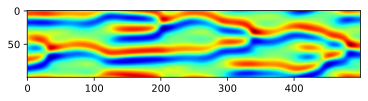

In [12]:
plt.imshow(prediction[:500].T, cmap='jet')

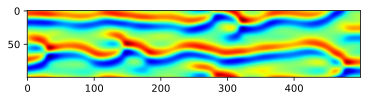

In [13]:
plt.imshow(data_test[:500].T, cmap='jet')

# Check code:

In [3]:
scaling = (0.4, 0.9, 0.4)
renorm = 0.11
alpha = 1e-2
N_train = 10000
N_init = 50
dot_fn = weighted_dot(*scaling)

In [4]:
K_train, uu = recurrent_kernel(data_train, erf_kernel, scaling)
W_out = train(K_train, data_train, alpha, renorm, n_init=50)

In [5]:
prediction, _ = predict(data_train, erf_kernel, dot_fn, uu, K_train, W_out, N_init, renorm, length=2000)

In [8]:
%%timeit
predict(data_train, erf_kernel, dot_fn, uu, K_train, W_out, N_init, renorm, length=2000)

94.8 ms ± 43.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
